In [1]:
!pip install pandas numpy transformers torch nltk scikit-learn wordcloud matplotlib streamlit



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 68.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import streamlit as st
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re
import joblib

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
#Load the data

data = pd.read_csv(r"/content/Flipkart_Products_Review_Dataset_SentimentAnalysis.csv",encoding='ISO-8859-1')
data

/tmp/ipython-input-1182242077.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(r"/content/Flipkart_Products_Review_Dataset_SentimentAnalysis.csv",encoding='ISO-8859-1')


,Product_name,Price,Rate,Review,Summary
0,"Crompton 75 L Desert Air Cooler??(White, Tea...","??10,499",5,Simply awesome,it's really worth every single penny. it works...
1,"Crompton 75 L Desert Air Cooler??(White, Tea...","??10,499",4,Worth the money . Desert Cooler live up to the...,I bought Crompton Ozone 75 Desert Air Cooler i...
2,"Crompton 75 L Desert Air Cooler??(White, Tea...","??10,499",5,Worth every penny,GREAT packaging by seller. As this was the mos...
3,"Crompton 75 L Desert Air Cooler??(White, Tea...","??10,499",5,Fabulous!,Delivery was delayed by two days except this e...
4,"Crompton 75 L Desert Air Cooler??(White, Tea...","??10,499",4,Nice product,A Good cooler by Crompton. The height of the c...
...,...,...,...,...,...
363256,"NIVEA Soft Light Moisturizer for Face, Hand & ...",??142,5.0,Terrific,Thanks
363257,"NIVEA Soft Light Moisturizer for Face, Hand & ...",??142,5.0,Terrific,Good
363258,"NIVEA Soft Light Moisturizer for Face, Hand & ...",??142,5.0,Just wow!,Super
363259,"NIVEA Soft Light Moisturizer for Face, Hand & ...",??142,4.0,Worth the money,Good


In [4]:
data.shape

(363261, 5)

In [5]:
#Column names

print(f"Feature names : {data.columns.values}")

Feature names : ['Product_name' 'Price' 'Rate' 'Review' 'Summary']


In [6]:
#Check for null values

data.isnull().sum()

,0
Product_name,15
Price,16
Rate,16
Review,22
Summary,2022


In [7]:
#Getting the record where 'Review' is null

data[data['Review'].isna() == True]

,Product_name,Price,Rate,Review,Summary
39529,Woven Beanie,???219,5,NaN,NaN
39542,Woven Beanie,???219,4,NaN,NaN
101431,BAJAJ Fx11 Food Factory 600 W Food Processor?...,"??6,525",2,NaN,"Within a month, main Jar of the product got tw..."
187221,NaN,NaN,NaN,NaN,NaN
187222,NaN,NaN,NaN,NaN,NaN
187223,NaN,NaN,NaN,NaN,NaN
187224,NaN,NaN,NaN,NaN,NaN
187225,NaN,NaN,NaN,NaN,NaN
187226,NaN,NaN,NaN,NaN,NaN
187227,NaN,NaN,NaN,NaN,NaN


In [8]:
#drop the null record

data.dropna(inplace=True)

In [9]:
print(f"Dataset shape after dropping null values : {data.shape}")

Dataset shape after dropping null values : (361235, 5)


In [10]:
#Creating a new column 'length' that will contain the length of the string in 'Review' column

data['length'] = data['Review'].apply(len)

In [11]:
data

,Product_name,Price,Rate,Review,Summary,length
0,"Crompton 75 L Desert Air Cooler??(White, Tea...","??10,499",5,Simply awesome,it's really worth every single penny. it works...,14
1,"Crompton 75 L Desert Air Cooler??(White, Tea...","??10,499",4,Worth the money . Desert Cooler live up to the...,I bought Crompton Ozone 75 Desert Air Cooler i...,53
2,"Crompton 75 L Desert Air Cooler??(White, Tea...","??10,499",5,Worth every penny,GREAT packaging by seller. As this was the mos...,17
3,"Crompton 75 L Desert Air Cooler??(White, Tea...","??10,499",5,Fabulous!,Delivery was delayed by two days except this e...,9
4,"Crompton 75 L Desert Air Cooler??(White, Tea...","??10,499",4,Nice product,A Good cooler by Crompton. The height of the c...,12
...,...,...,...,...,...,...
363255,"NIVEA Soft Light Moisturizer for Face, Hand & ...",??142,5.0,Terrific,Good,8
363256,"NIVEA Soft Light Moisturizer for Face, Hand & ...",??142,5.0,Terrific,Thanks,8
363257,"NIVEA Soft Light Moisturizer for Face, Hand & ...",??142,5.0,Terrific,Good,8
363258,"NIVEA Soft Light Moisturizer for Face, Hand & ...",??142,5.0,Just wow!,Super,9


In [12]:
data['Product_name'].value_counts()

,count
Product_name,
Bumtum Baby Pull-Up Diaper Pants Combo Pack - L??(186 Pieces),9937
"MILTON Thermosteel Flip Lid 500 ml Flask??(Pack of 1, Silver, Steel)",9278
"cello Pack of 18 Opalware Cello Dazzle Lush Fiesta Opalware Dinner Set, 18 Pieces Dinner Set??(White, Microwave Safe)",8870
"PHILIPS SPA4040B/94 45 W Bluetooth Home Theatre??(Black, 5.1 Channel)",8693
Mi 5A 80 cm (32 inch) HD Ready LED Smart Android TV with Dolby Audio (2022 Model),8222
...,...
APPLE iPad Air (5th gen) 64 GB ROM 10.9 Inch with Wi-Fi+5G (Blue),3
APPLE iPad mini (6th Gen) 256 GB ROM 8.3 inch with Wi-Fi Only (Pink),3
APPLE iPad mini (6th Gen) 256 GB ROM 8.3 inch with Wi-Fi+5G (Starlight),3


In [13]:
# Define a cleaning function
def clean_product_name(name):
    # Convert to string just in case
    name = str(name)

    # Remove non-ASCII characters (like �, , ™, etc.)
    name = name.encode('ascii', 'ignore').decode('ascii')

    # Remove unwanted punctuation and symbols
    name = re.sub(r'[^\w\s\-.,]', '', name)  # keep letters, numbers, spaces, dash, dot, comma

    # Remove multiple spaces
    name = re.sub(r'\s+', ' ', name).strip()

    return name

# Apply to your column
data['Product_name'] = data['Product_name'].apply(clean_product_name)



In [14]:
data['Product_name'].value_counts()

,count
Product_name,
Bumtum Baby Pull-Up Diaper Pants Combo Pack - L186 Pieces,9937
"MILTON Thermosteel Flip Lid 500 ml FlaskPack of 1, Silver, Steel",9278
"cello Pack of 18 Opalware Cello Dazzle Lush Fiesta Opalware Dinner Set, 18 Pieces Dinner SetWhite, Microwave Safe",8870
"PHILIPS SPA4040B94 45 W Bluetooth Home TheatreBlack, 5.1 Channel",8693
Mi 5A 80 cm 32 inch HD Ready LED Smart Android TV with Dolby Audio 2022 Model,8222
...,...
APPLE iPad Air 5th gen 64 GB ROM 10.9 Inch with Wi-Fi5G Blue,3
APPLE iPad mini 6th Gen 256 GB ROM 8.3 inch with Wi-Fi Only Pink,3
APPLE iPad Air 5th gen 64 GB ROM 10.9 Inch with Wi-Fi5G Purple,3


In [15]:
data['Price'].value_counts()

,count
Price,
"??4,499",12633
"??10,499",11409
"??1,299",10163
"??1,353",9937
"??13,999",9627
...,...
"??57,900",3
product_name,3
"Pigeon Favourite Electric Kettle????(1.5 L, Silver, Black)",1


In [16]:
# Step 1: Convert everything to string
data['Price'] = data['Price'].astype(str)

# Step 2: Remove unwanted symbols (₹, Rs., commas, spaces, etc.)
data['Price'] = data['Price'].str.replace(r'[,?,₹,Rs.\s]', '', regex=True)

# Step 3: Replace empty strings with NaN
data['Price'] = data['Price'].replace('', np.nan)

# Step 4: Convert to numeric (non-numeric → NaN)
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')

# Step 5: Fill missing values (optional) — here using median
data['Price'].fillna(data['Price'].median(), inplace=True)

# Step 6: Convert to integer safely
data['Price'] = data['Price'].astype(int)

/tmp/ipython-input-3049050041.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Price'].fillna(data['Price'].median(), inplace=True)


In [17]:
data['Price'].value_counts()

,count
Price,
4499,12633
10499,11409
1299,10333
13999,10249
1353,9937
...,...
63900,9
68900,9
74900,8


In [18]:
data.dtypes

,0
Product_name,object
Price,int64
Rate,object
Review,object
Summary,object
length,int64


In [19]:
#Distinct values of 'rating' and its count

print(f"Rating value count: \n{data['Rate'].value_counts()}")

Rating value count: 
Rate
5                                                              145636
5.0                                                             57066
4                                                               53451
1                                                               28190
3                                                               23537
4.0                                                             20409
1.0                                                             11702
2                                                                9303
3.0                                                              8334
2.0                                                              3601
product_name                                                        3
Pigeon Favourite Electric Kettle????(1.5 L, Silver, Black)          1
Nova Plus Amaze NI 10 1100 W Dry Iron????(Grey & Turquoise)         1
Bajaj DX 2 L/W Dry Iron                                         

In [20]:
# Convert all rating values like 5.0 → 5, 4.0 → 4, etc.
data['Rate'] = pd.to_numeric(data['Rate'], errors='coerce')   # ensure numeric
data['Rate'] = data['Rate'].astype('Int64')                   # convert all to integer


In [21]:
#Distinct values of 'rating' and its count

print(f"Rating value count: \n{data['Rate'].value_counts()}")

Rating value count: 
Rate
5    202702
4     73860
1     39892
3     31871
2     12904
Name: count, dtype: Int64


In [22]:
data['Review'].value_counts()

,count
Review,
Wonderful,18567
Awesome,11487
Great product,11299
Best in the market!,11270
Classy product,11217
...,...
Super good,1
Great but not fit for india,1
Google Home Mini Flop,1


In [23]:
#No Need to clean the Review

In [24]:
data['Summary'].value_counts()

,count
Summary,
Good,25001
Nice,13100
Good product,8865
Nice product,6275
Super,4983
...,...
insulation not good.. hot water gets cool in short time,1
Good in quality ???,1
very good brand,1


In [25]:
data.shape

(361235, 6)

In [26]:
def clean_summary(text):
    # Convert to string safely
    text = str(text)

    # Remove non-ASCII (like �  ðŸ˜ etc.)
    text = text.encode('ascii', 'ignore').decode('ascii')

    # Remove long runs of question marks or symbols
    text = re.sub(r'\?+', '', text)

    # Remove unwanted characters (keep letters, digits, punctuation)
    text = re.sub(r'[^a-zA-Z0-9.,!?\'\"()\s]', '', text)

    # Remove repeated dots like '.....' → '.'
    text = re.sub(r'\.{2,}', '.', text)

    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # If empty after cleaning, return np.nan instead of removing the row
    if text == '' or text.lower() in ['nan', 'none']:
        return np.nan
    else:
        return text

# Apply to Summary column
data['Summary'] = data['Summary'].apply(clean_summary)
# Fill missing summaries (so you don’t lose rows)
data['Summary'].fillna("No Summary Available", inplace=True)

/tmp/ipython-input-2472001014.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Summary'].fillna("No Summary Available", inplace=True)


In [27]:
data['Summary'].value_counts()

,count
Summary,
Good,26333
Nice,14540
Good product,9932
Nice product,7296
Super,5472
...,...
Realistic mm Milton product.and value of money,1
Nice product.value for money.,1
Very good product original Milton product in this price I am happy,1


In [28]:
data.shape

(361235, 6)

In [29]:
data

,Product_name,Price,Rate,Review,Summary,length
0,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,5,Simply awesome,it's really worth every single penny. it works...,14
1,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,4,Worth the money . Desert Cooler live up to the...,I bought Crompton Ozone 75 Desert Air Cooler i...,53
2,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,5,Worth every penny,GREAT packaging by seller. As this was the mos...,17
3,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,5,Fabulous!,Delivery was delayed by two days except this e...,9
4,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,4,Nice product,A Good cooler by Crompton. The height of the c...,12
...,...,...,...,...,...,...
363255,"NIVEA Soft Light Moisturizer for Face, Hand Bo...",142,5,Terrific,Good,8
363256,"NIVEA Soft Light Moisturizer for Face, Hand Bo...",142,5,Terrific,Thanks,8
363257,"NIVEA Soft Light Moisturizer for Face, Hand Bo...",142,5,Terrific,Good,8
363258,"NIVEA Soft Light Moisturizer for Face, Hand Bo...",142,5,Just wow!,Super,9


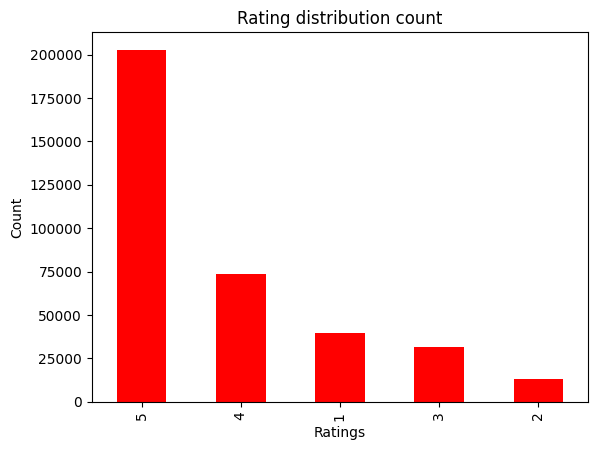

In [30]:
#Bar plot to visualize the total counts of each rating

data['Rate'].value_counts().plot.bar(color = 'red')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [31]:
#Finding the percentage distribution of each rating - we'll divide the number of records for each rating by total number of records

print(f"Rating value count - percentage distribution: \n{round(data['Rate'].value_counts()/data.shape[0]*100,2)}")

Rating value count - percentage distribution: 
Rate
5    56.11
4    20.45
1    11.04
3     8.82
2     3.57
Name: count, dtype: Float64


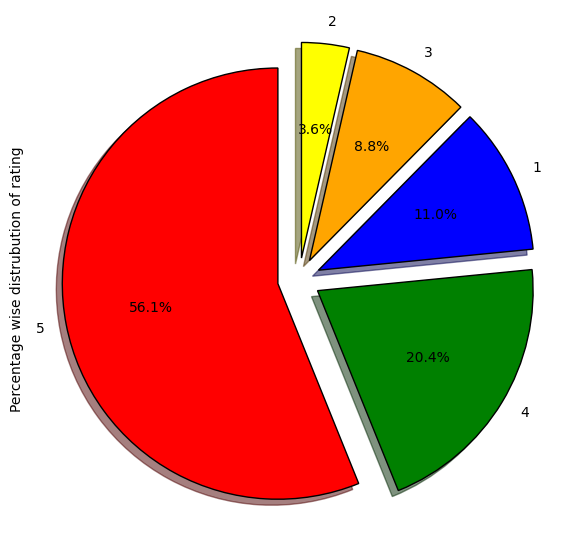

In [32]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green', 'blue','orange','yellow')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['Rate'].value_counts()/data.shape[0]

explode=(0.1,0.1,0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

In [33]:
def map_sentiment(rate):
    if rate >= 4:
        return "positive"
    elif rate == 3:
        return "neutral"
    else:
        return "negative"

data['Sentiment'] = data['Rate'].apply(map_sentiment)


In [34]:
data

,Product_name,Price,Rate,Review,Summary,length,Sentiment
0,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,5,Simply awesome,it's really worth every single penny. it works...,14,positive
1,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,4,Worth the money . Desert Cooler live up to the...,I bought Crompton Ozone 75 Desert Air Cooler i...,53,positive
2,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,5,Worth every penny,GREAT packaging by seller. As this was the mos...,17,positive
3,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,5,Fabulous!,Delivery was delayed by two days except this e...,9,positive
4,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,4,Nice product,A Good cooler by Crompton. The height of the c...,12,positive
...,...,...,...,...,...,...,...
363255,"NIVEA Soft Light Moisturizer for Face, Hand Bo...",142,5,Terrific,Good,8,positive
363256,"NIVEA Soft Light Moisturizer for Face, Hand Bo...",142,5,Terrific,Thanks,8,positive
363257,"NIVEA Soft Light Moisturizer for Face, Hand Bo...",142,5,Terrific,Good,8,positive
363258,"NIVEA Soft Light Moisturizer for Face, Hand Bo...",142,5,Just wow!,Super,9,positive


In [35]:
data['Sentiment'].value_counts()

,count
Sentiment,
positive,276562
negative,52802
neutral,31871


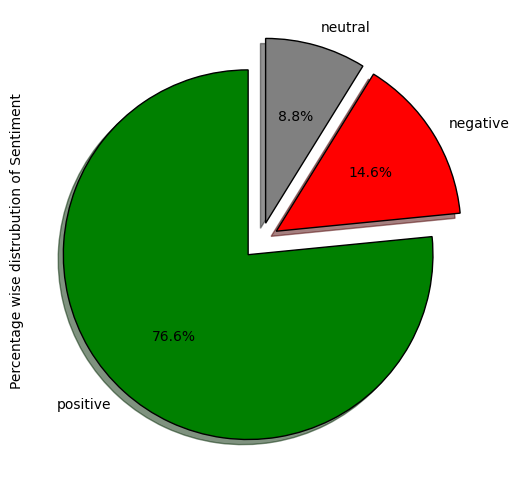

In [36]:
fig = plt.figure(figsize=(6,6))

colors = ('green','red','#808080')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['Sentiment'].value_counts()/data.shape[0]

explode=(0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of Sentiment')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

In [37]:
data['Text_review'] = data['Review'].fillna('') + ' ' + data['Summary'].fillna('')

In [38]:
data['length'] = data['Text_review'].apply(len)

In [39]:
data

,Product_name,Price,Rate,Review,Summary,length,Sentiment,Text_review
0,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,5,Simply awesome,it's really worth every single penny. it works...,500,positive,Simply awesome it's really worth every single ...
1,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,4,Worth the money . Desert Cooler live up to the...,I bought Crompton Ozone 75 Desert Air Cooler i...,543,positive,Worth the money . Desert Cooler live up to the...
2,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,5,Worth every penny,GREAT packaging by seller. As this was the mos...,515,positive,Worth every penny GREAT packaging by seller. A...
3,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,5,Fabulous!,Delivery was delayed by two days except this e...,413,positive,Fabulous! Delivery was delayed by two days exc...
4,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,4,Nice product,A Good cooler by Crompton. The height of the c...,492,positive,Nice product A Good cooler by Crompton. The he...
...,...,...,...,...,...,...,...,...
363255,"NIVEA Soft Light Moisturizer for Face, Hand Bo...",142,5,Terrific,Good,13,positive,Terrific Good
363256,"NIVEA Soft Light Moisturizer for Face, Hand Bo...",142,5,Terrific,Thanks,15,positive,Terrific Thanks
363257,"NIVEA Soft Light Moisturizer for Face, Hand Bo...",142,5,Terrific,Good,13,positive,Terrific Good
363258,"NIVEA Soft Light Moisturizer for Face, Hand Bo...",142,5,Just wow!,Super,15,positive,Just wow! Super


In [40]:
data.shape

(361235, 8)

In [41]:
data['Text_review'].unique()

array(["Simply awesome it's really worth every single penny. it works like one ton AC provided that your room has proper ventilation. I generally keep cooler near to window so that it can pull fresh air from outside and as a result I get very cool air. one more suggestion, please don't buy cooler which are equipped with a blower fan. Always go for the cooler equipped with metal fan like this one. In one word, this Compton cooler is Amazing. if you find the review helpful, please thumps up. Happy summer!",
       'Worth the money . Desert Cooler live up to the Name . I bought Crompton Ozone 75 Desert Air Cooler in the Month of May 2018 . Summer at its Peak . I live on top floor so my house gets mare warmer in comparison to other flats . Placed the Air Cooler in Hall near balcony . The device is elegantly build and performs very well . Crompton has introduced a very good product . Pros1. Sleek design . 2. water tank excellent .3. Wheel are very good in quality , no problem in mobility ev

In [42]:
data['Text_review'].value_counts()

,count
Text_review,
Wonderful Good,1613
Nice product Good,960
Good choice Good,898
Pretty good Good,890
Good quality product Good,890
...,...
Great product Best product ever must buy,1
Delightful Soft good,1
Brilliant Loved the product.The delivery was on time.Thank you.,1


In [43]:
import re

def clean_Text_review(Text_review):
    # Convert to string and lowercase
    Text_review = str(Text_review).lower()

    # Remove non-breaking and junk unicode characters (like �  ™)
    Text_review = Text_review.encode('ascii', 'ignore').decode('ascii')

    # Add spaces around punctuation before removing (prevents word merging)
    Text_review = re.sub(r'([.,!?()\-])', r' \1 ', Text_review)

    # Remove URLs
    Text_review = re.sub(r'http\S+|www\S+|https\S+', ' ', Text_review)

    # Remove HTML tags
    Text_review = re.sub(r'<.*?>', ' ', Text_review)

    # ✅ Keep digits (remove only unwanted special characters)
    Text_review = re.sub(r'[^a-zA-Z0-9\s]', ' ', Text_review)

    # Remove repeated punctuation or junk sequences
    Text_review = re.sub(r'\?+', ' ', Text_review)
    Text_review = re.sub(r'\!+', ' ', Text_review)
    Text_review = re.sub(r'\.+', ' ', Text_review)

    # Remove multiple spaces
    Text_review = re.sub(r'\s+', ' ', Text_review).strip()

    return Text_review

# Apply cleaning to your Text_review column
data['Text_review'] = data['Text_review'].astype(str).apply(clean_Text_review)

In [44]:
data.Text_review

,Text_review
0,simply awesome it s really worth every single ...
1,worth the money desert cooler live up to the n...
2,worth every penny great packaging by seller as...
3,fabulous delivery was delayed by two days exce...
4,nice product a good cooler by crompton the hei...
...,...
363255,terrific good
363256,terrific thanks
363257,terrific good
363258,just wow super


In [45]:
data

,Product_name,Price,Rate,Review,Summary,length,Sentiment,Text_review
0,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,5,Simply awesome,it's really worth every single penny. it works...,500,positive,simply awesome it s really worth every single ...
1,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,4,Worth the money . Desert Cooler live up to the...,I bought Crompton Ozone 75 Desert Air Cooler i...,543,positive,worth the money desert cooler live up to the n...
2,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,5,Worth every penny,GREAT packaging by seller. As this was the mos...,515,positive,worth every penny great packaging by seller as...
3,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,5,Fabulous!,Delivery was delayed by two days except this e...,413,positive,fabulous delivery was delayed by two days exce...
4,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,4,Nice product,A Good cooler by Crompton. The height of the c...,492,positive,nice product a good cooler by crompton the hei...
...,...,...,...,...,...,...,...,...
363255,"NIVEA Soft Light Moisturizer for Face, Hand Bo...",142,5,Terrific,Good,13,positive,terrific good
363256,"NIVEA Soft Light Moisturizer for Face, Hand Bo...",142,5,Terrific,Thanks,15,positive,terrific thanks
363257,"NIVEA Soft Light Moisturizer for Face, Hand Bo...",142,5,Terrific,Good,13,positive,terrific good
363258,"NIVEA Soft Light Moisturizer for Face, Hand Bo...",142,5,Just wow!,Super,15,positive,just wow super


In [46]:
data.Text_review[20]

'utterly disappointed never purchase cooler from flipkartmy 10500 wastedpump not working honey comb dry not giving cool air the up and down slider is also not working when you manually do it up it will go down itself after few minutes giving only air in downwardi am a regular flipkart customer and was trusting flipkart but after this cooler purchasing experience i hate flipkart from now and i ll never do any order at flipkarti ve requested for return that was 7 days replacement policy buttechnician came and'

In [47]:
data.Sentiment[20]

'negative'

In [48]:
X = data['Text_review']
y = data['Sentiment']

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
#Logistic Regression Model
log_model = LogisticRegression(max_iter=2500)
log_model.fit(X_train_vec, y_train)

y_pred = log_model.predict(X_test_vec)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Save Model
joblib.dump(log_model, "Logistic_Regression_Model.pkl")
joblib.dump(vectorizer, "TFIDF_Vectorizer.pkl")


Accuracy: 0.9693689703378687

Classification Report:
               precision    recall  f1-score   support

    negative       0.97      0.96      0.96     10544
     neutral       0.91      0.80      0.85      6348
    positive       0.98      0.99      0.98     55355

    accuracy                           0.97     72247
   macro avg       0.95      0.92      0.93     72247
weighted avg       0.97      0.97      0.97     72247



['TFIDF_Vectorizer.pkl']

In [52]:
data

,Product_name,Price,Rate,Review,Summary,length,Sentiment,Text_review
0,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,5,Simply awesome,it's really worth every single penny. it works...,500,positive,simply awesome it s really worth every single ...
1,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,4,Worth the money . Desert Cooler live up to the...,I bought Crompton Ozone 75 Desert Air Cooler i...,543,positive,worth the money desert cooler live up to the n...
2,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,5,Worth every penny,GREAT packaging by seller. As this was the mos...,515,positive,worth every penny great packaging by seller as...
3,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,5,Fabulous!,Delivery was delayed by two days except this e...,413,positive,fabulous delivery was delayed by two days exce...
4,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,4,Nice product,A Good cooler by Crompton. The height of the c...,492,positive,nice product a good cooler by crompton the hei...
...,...,...,...,...,...,...,...,...
363255,"NIVEA Soft Light Moisturizer for Face, Hand Bo...",142,5,Terrific,Good,13,positive,terrific good
363256,"NIVEA Soft Light Moisturizer for Face, Hand Bo...",142,5,Terrific,Thanks,15,positive,terrific thanks
363257,"NIVEA Soft Light Moisturizer for Face, Hand Bo...",142,5,Terrific,Good,13,positive,terrific good
363258,"NIVEA Soft Light Moisturizer for Face, Hand Bo...",142,5,Just wow!,Super,15,positive,just wow super


In [ ]:
#Support Vector Machine (SVM)
from sklearn.svm import LinearSVC

svm_model = LinearSVC()
svm_model.fit(X_train_vec, y_train)

y_pred = svm_model.predict(X_test_vec)

print("SVM Accuracy:", accuracy_score(y_test, y_pred))
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred))

# Save Model
joblib.dump(svm_model, "SVM_Model.pkl")
joblib.dump(vectorizer, "TFIDF_Vectorizer.pkl")


SVM Accuracy: 0.9685523274322809

SVM Classification Report:
               precision    recall  f1-score   support

    negative       0.96      0.96      0.96     10544
     neutral       0.91      0.80      0.85      6348
    positive       0.98      0.99      0.98     55355

    accuracy                           0.97     72247
   macro avg       0.95      0.92      0.93     72247
weighted avg       0.97      0.97      0.97     72247



['TFIDF_Vectorizer.pkl']

In [ ]:
#Naive Bayes (MultinomialNB)
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)

y_pred = nb_model.predict(X_test_vec)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred))
print("\nNaive Bayes Classification Report:\n", classification_report(y_test, y_pred))

joblib.dump(nb_model, "Naive_Bayes_Model.pkl")


Naive Bayes Accuracy: 0.9466829072487439

Naive Bayes Classification Report:
               precision    recall  f1-score   support

    negative       0.93      0.93      0.93     10544
     neutral       0.91      0.61      0.73      6348
    positive       0.95      0.99      0.97     55355

    accuracy                           0.95     72247
   macro avg       0.93      0.84      0.88     72247
weighted avg       0.95      0.95      0.94     72247



['Naive_Bayes_Model.pkl']

In [53]:
# Map text labels to numeric values
mapping = {
    "positive": 2,
    "neutral": 1,
    "negative": 0
}

data['Sentiment_Label'] = data['Sentiment'].map(mapping)


In [54]:
data

,Product_name,Price,Rate,Review,Summary,length,Sentiment,Text_review,Sentiment_Label
0,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,5,Simply awesome,it's really worth every single penny. it works...,500,positive,simply awesome it s really worth every single ...,2
1,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,4,Worth the money . Desert Cooler live up to the...,I bought Crompton Ozone 75 Desert Air Cooler i...,543,positive,worth the money desert cooler live up to the n...,2
2,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,5,Worth every penny,GREAT packaging by seller. As this was the mos...,515,positive,worth every penny great packaging by seller as...,2
3,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,5,Fabulous!,Delivery was delayed by two days except this e...,413,positive,fabulous delivery was delayed by two days exce...,2
4,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,4,Nice product,A Good cooler by Crompton. The height of the c...,492,positive,nice product a good cooler by crompton the hei...,2
...,...,...,...,...,...,...,...,...,...
363255,"NIVEA Soft Light Moisturizer for Face, Hand Bo...",142,5,Terrific,Good,13,positive,terrific good,2
363256,"NIVEA Soft Light Moisturizer for Face, Hand Bo...",142,5,Terrific,Thanks,15,positive,terrific thanks,2
363257,"NIVEA Soft Light Moisturizer for Face, Hand Bo...",142,5,Terrific,Good,13,positive,terrific good,2
363258,"NIVEA Soft Light Moisturizer for Face, Hand Bo...",142,5,Just wow!,Super,15,positive,just wow super,2


In [55]:
data.Sentiment_Label[20]

np.int64(0)

In [56]:
w=data['Sentiment_Label']

In [57]:
w_train, w_test = train_test_split(w, test_size=0.2,random_state=42)

In [ ]:
#XGBoost
!pip install xgboost

from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb_model.fit(X_train_vec, w_train)

w_pred = xgb_model.predict(X_test_vec)

print("XGBoost Accuracy:", accuracy_score(w_test, w_pred))
print("\nXGBoost Classification Report:\n", classification_report(w_test, w_pred))

joblib.dump(xgb_model, "XGBoost_Model.pkl")


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [10:03:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.9737151715642172

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97     10544
           1       0.91      0.84      0.88      6348
           2       0.98      0.99      0.98     55355

    accuracy                           0.97     72247
   macro avg       0.96      0.93      0.94     72247
weighted avg       0.97      0.97      0.97     72247



['XGBoost_Model.pkl']

In [ ]:
#LightGBM
!pip install lightgbm

from lightgbm import LGBMClassifier

lgb_model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
lgb_model.fit(X_train_vec, w_train)

w_pred = lgb_model.predict(X_test_vec)

print("LightGBM Accuracy:", accuracy_score(w_test, w_pred))
print("\nLightGBM Classification Report:\n", classification_report(w_test, w_pred))

joblib.dump(lgb_model, "LightGBM_Model.pkl")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 20.523444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 148202
[LightGBM] [Info] Number of data points in the train set: 288988, number of used features: 3883
[LightGBM] [Info] Start training from score -1.922591
[LightGBM] [Info] Start training from score -2.426805
[LightGBM] [Info] Start training from score -0.267286


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Accuracy: 0.9771755228590806

LightGBM Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97     10544
           1       0.90      0.87      0.89      6348
           2       0.98      0.99      0.99     55355

    accuracy                           0.98     72247
   macro avg       0.96      0.94      0.95     72247
weighted avg       0.98      0.98      0.98     72247



['LightGBM_Model.pkl']

In [59]:
#CatBoost
!pip install catboost

from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(iterations=300, learning_rate=0.1, depth=6, verbose=0, random_state=42)
cat_model.fit(X_train_vec, w_train)

w_pred = cat_model.predict(X_test_vec)

print("CatBoost Accuracy:", accuracy_score(w_test, w_pred))
print("\nCatBoost Classification Report:\n", classification_report(w_test, w_pred))

joblib.dump(cat_model, "CatBoost_Model.pkl")


  Using cached catboost-1.2.8-cp312-cp312-manylinux2014_x86_64.whl.metadata (1.2 kB)
Using cached catboost-1.2.8-cp312-cp312-manylinux2014_x86_64.whl (99.2 MB)
CatBoost Accuracy: 0.9659916674740819

CatBoost Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96     10544
           1       0.93      0.77      0.84      6348
           2       0.97      0.99      0.98     55355

    accuracy                           0.97     72247
   macro avg       0.96      0.90      0.93     72247
weighted avg       0.97      0.97      0.96     72247



['CatBoost_Model.pkl']

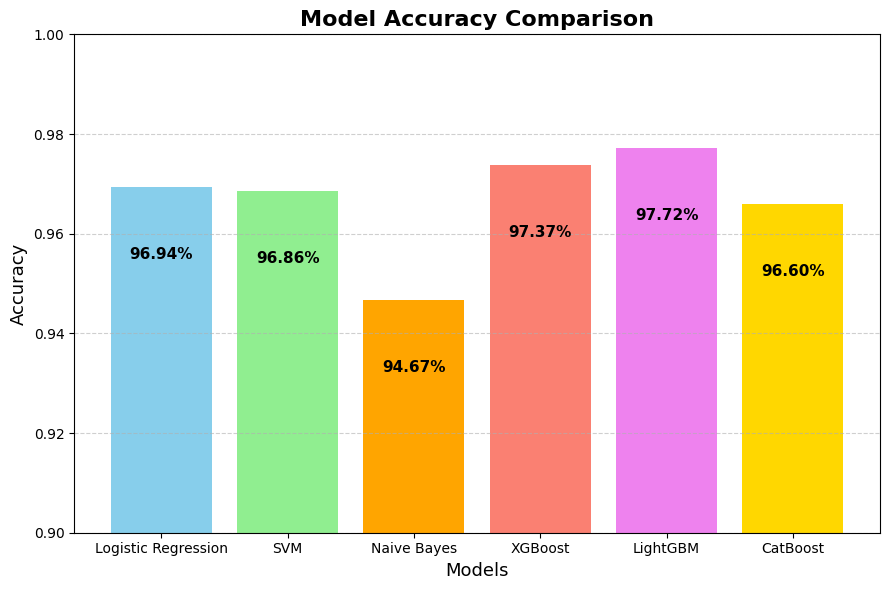

In [60]:
import matplotlib.pyplot as plt

# Model names and acc6uracies
models = ['Logistic Regression', 'SVM', 'Naive Bayes', 'XGBoost', 'LightGBM', 'CatBoost']
accuracies = [0.9693689703378687, 0.9685523274322809, 0.9466829072487439,
              0.9737151715642172, 0.9771755228590806, 0.9659916674740819]

# Plot
plt.figure(figsize=(9,6))
bars = plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'orange', 'salmon', 'violet', 'gold'])

# Add title and labels
plt.title("Model Accuracy Comparison", fontsize=16, fontweight='bold')
plt.xlabel("Models", fontsize=13)
plt.ylabel("Accuracy", fontsize=13)
plt.ylim(0.9, 1.0)   # set range for better visualization

# Add accuracy labels on each bar
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.015,
             f"{acc*100:.2f}%", ha='center', va='bottom', fontsize=11, fontweight='bold', color='black')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [61]:
#Logistics Model finalize because in deployment, speed and stability is more
sample_vec = vectorizer.transform(data['Text_review'])
data['Predicted_Sentiment'] = log_model.predict(sample_vec)


In [62]:
data.head()

,Product_name,Price,Rate,Review,Summary,length,Sentiment,Text_review,Sentiment_Label,Predicted_Sentiment
0,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,5,Simply awesome,it's really worth every single penny. it works...,500,positive,simply awesome it s really worth every single ...,2,positive
1,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,4,Worth the money . Desert Cooler live up to the...,I bought Crompton Ozone 75 Desert Air Cooler i...,543,positive,worth the money desert cooler live up to the n...,2,positive
2,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,5,Worth every penny,GREAT packaging by seller. As this was the mos...,515,positive,worth every penny great packaging by seller as...,2,positive
3,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,5,Fabulous!,Delivery was delayed by two days except this e...,413,positive,fabulous delivery was delayed by two days exce...,2,positive
4,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,4,Nice product,A Good cooler by Crompton. The height of the c...,492,positive,nice product a good cooler by crompton the hei...,2,positive


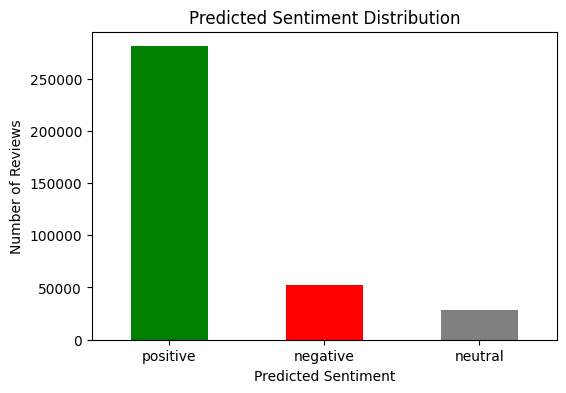

In [63]:
# Bar chart for model-predicted sentiment distribution
data['Predicted_Sentiment'].value_counts().plot(
    kind='bar',
    color=['green', 'red', 'grey'],
    figsize=(6,4)
)

plt.title('Predicted Sentiment Distribution')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.show()



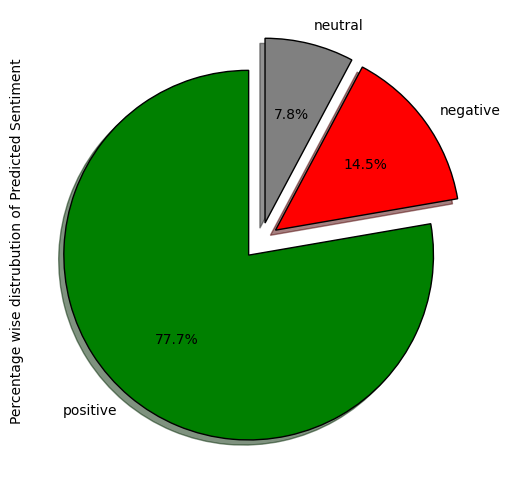

In [64]:
fig = plt.figure(figsize=(6,6))

colors = ('green','red','#808080')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['Predicted_Sentiment'].value_counts()/data.shape[0]

explode=(0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of Predicted Sentiment')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")


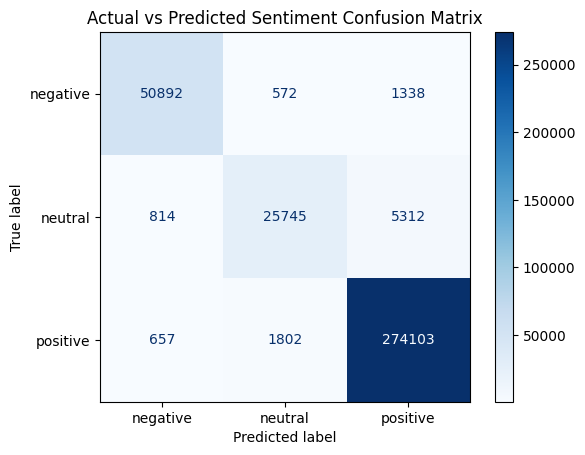

In [65]:
# Map actual ratings to sentiment
def map_sentiment(rate):
    if rate >= 4:
        return 'positive'
    elif rate == 3:
        return 'neutral'
    else:
        return 'negative'

data['Actual_Sentiment'] = data['Rate'].apply(map_sentiment)

# Compare actual vs predicted
ConfusionMatrixDisplay.from_predictions(
    data['Actual_Sentiment'],
    data['Predicted_Sentiment'],
    cmap='Blues'
)
plt.title("Actual vs Predicted Sentiment Confusion Matrix")
plt.show()


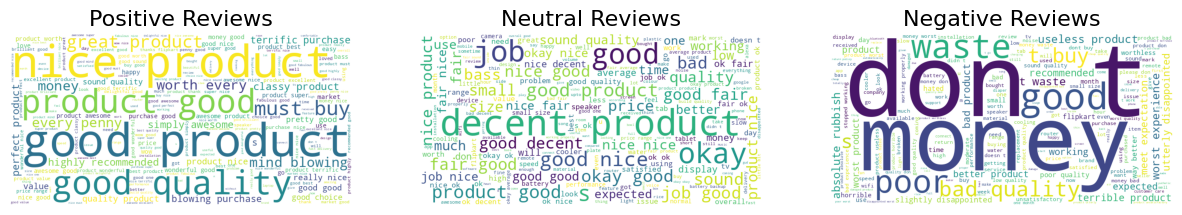

In [66]:
#Word Cloud for Sentiment Visualization

# Combine text for each sentiment type
positive_text = " ".join(data[data['Predicted_Sentiment'] == 'positive']['Text_review'])
neutral_text  = " ".join(data[data['Predicted_Sentiment'] == 'neutral']['Text_review'])
negative_text = " ".join(data[data['Predicted_Sentiment'] == 'negative']['Text_review'])

# Generate Word Clouds
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(WordCloud(width=800, height=400, background_color='white').generate(positive_text))
plt.title("Positive Reviews", fontsize=16)
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(WordCloud(width=800, height=400, background_color='white').generate(neutral_text))
plt.title("Neutral Reviews", fontsize=16)
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(WordCloud(width=800, height=400, background_color='white').generate(negative_text))
plt.title("Negative Reviews", fontsize=16)
plt.axis('off')

plt.show()


Top 10 Products by Positive Sentiment:



Predicted_Sentiment,negative,neutral,positive
Product_name,,,
"MILTON Thermosteel Flip Lid 500 ml FlaskPack of 1, Silver, Steel",482,522,8274
"cello Pack of 18 Opalware Cello Dazzle Lush Fiesta Opalware Dinner Set, 18 Pieces Dinner SetWhite, Microwave Safe",575,699,7596
"Lakm Eyeconic Kajal Twin PackDeep Black, 0.7 g",256,433,7529
Mi 5A 80 cm 32 inch HD Ready LED Smart Android TV with Dolby Audio 2022 Model,639,471,7112
"PHILIPS SPA4040B94 45 W Bluetooth Home TheatreBlack, 5.1 Channel",1329,658,6706
Bumtum Baby Pull-Up Diaper Pants Combo Pack - L186 Pieces,2454,812,6671
"PHILIPS SPA8140B94 38 W Bluetooth Home TheatreBlack, 4.1 Channel",1221,613,6080
Google Home Mini with Google Assistant Smart SpeakerCharcoal,969,527,5894
Ephemeral LCD Writing 8.5 Inch Tablet Electronic Writing Drawing Doodle Board GREENMulticolor,894,509,4473


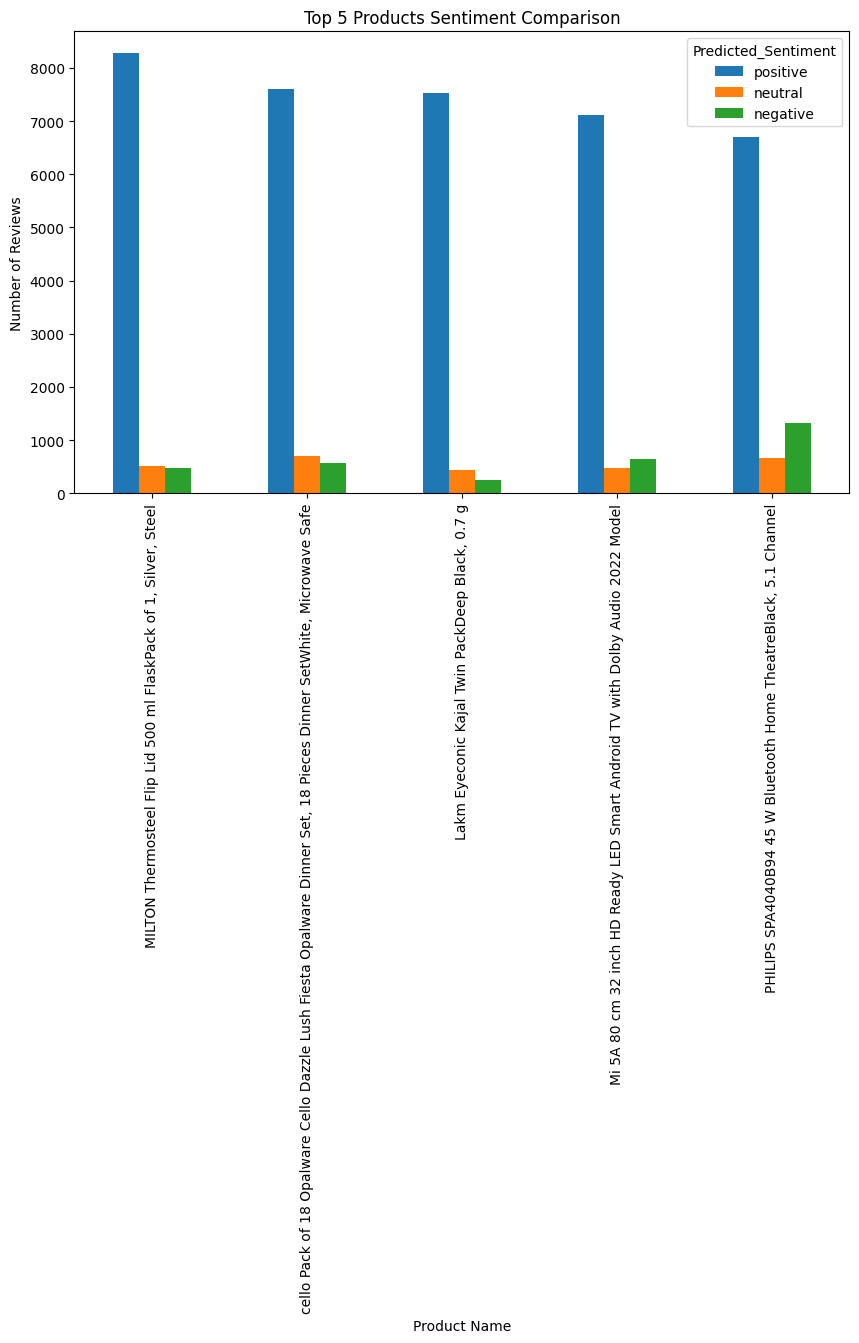

In [67]:
#Product-wise Sentiment Summary
product_summary = data.groupby(['Product_name', 'Predicted_Sentiment']).size().unstack(fill_value=0)

# Sort by most positive reviews
product_summary = product_summary.sort_values(by='positive', ascending=False)

print("Top 10 Products by Positive Sentiment:\n")
display(product_summary.head(10))

# Plot top 5 products comparison
product_summary[['positive', 'neutral', 'negative']].head(5).plot(
    kind='bar', figsize=(10,6)
)
plt.title("Top 5 Products Sentiment Comparison")
plt.xlabel("Product Name")
plt.ylabel("Number of Reviews")
plt.show()


In [68]:
data.columns

Index(['Product_name', 'Price', 'Rate', 'Review', 'Summary', 'length',
       'Sentiment', 'Text_review', 'Sentiment_Label', 'Predicted_Sentiment',
       'Actual_Sentiment'],
      dtype='object')

Correlation between Price and Sentiment: -0.009


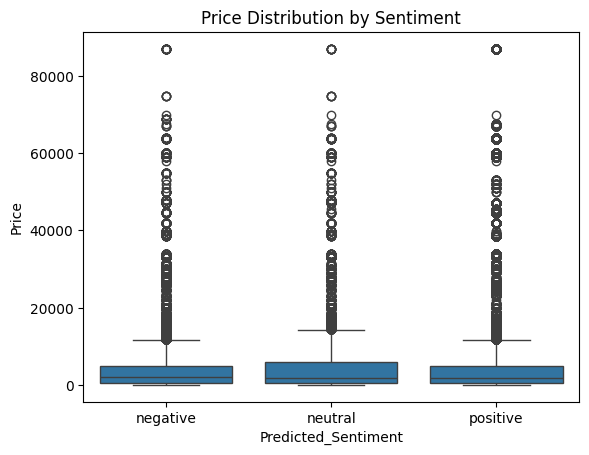

In [69]:
corr = data['Price'].corr(data['Sentiment_Label'])
print("Correlation between Price and Sentiment:", round(corr, 3))

sns.boxplot(x='Predicted_Sentiment', y='Price', data=data, order=['negative','neutral','positive'])
plt.title("Price Distribution by Sentiment")
plt.show()


In [70]:
data

,Product_name,Price,Rate,Review,Summary,length,Sentiment,Text_review,Sentiment_Label,Predicted_Sentiment,Actual_Sentiment
0,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,5,Simply awesome,it's really worth every single penny. it works...,500,positive,simply awesome it s really worth every single ...,2,positive,positive
1,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,4,Worth the money . Desert Cooler live up to the...,I bought Crompton Ozone 75 Desert Air Cooler i...,543,positive,worth the money desert cooler live up to the n...,2,positive,positive
2,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,5,Worth every penny,GREAT packaging by seller. As this was the mos...,515,positive,worth every penny great packaging by seller as...,2,positive,positive
3,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,5,Fabulous!,Delivery was delayed by two days except this e...,413,positive,fabulous delivery was delayed by two days exce...,2,positive,positive
4,"Crompton 75 L Desert Air CoolerWhite, Teal, AC...",10499,4,Nice product,A Good cooler by Crompton. The height of the c...,492,positive,nice product a good cooler by crompton the hei...,2,positive,positive
...,...,...,...,...,...,...,...,...,...,...,...
363255,"NIVEA Soft Light Moisturizer for Face, Hand Bo...",142,5,Terrific,Good,13,positive,terrific good,2,positive,positive
363256,"NIVEA Soft Light Moisturizer for Face, Hand Bo...",142,5,Terrific,Thanks,15,positive,terrific thanks,2,positive,positive
363257,"NIVEA Soft Light Moisturizer for Face, Hand Bo...",142,5,Terrific,Good,13,positive,terrific good,2,positive,positive
363258,"NIVEA Soft Light Moisturizer for Face, Hand Bo...",142,5,Just wow!,Super,15,positive,just wow super,2,positive,positive


In [71]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib
import re

# -------------------------------
# Load model and vectorizer
# -------------------------------
@st.cache_resource
def load_artifacts():
    model = joblib.load("Logistic_Regression_Model.pkl")
    vectorizer = joblib.load("TFIDF_Vectorizer.pkl")
    return model, vectorizer

model, vectorizer = load_artifacts()

# -------------------------------
# Text cleaning function
# -------------------------------
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# -------------------------------
# Issue detection function
# -------------------------------
def detect_issue(text):
    text = text.lower()
    if any(word in text for word in ['not working', 'defective', 'broken', 'damaged', 'stop']):
        return "Product Quality Issue"
    elif any(word in text for word in ['leak', 'water', 'spill', 'crack']):
        return "Design / Material Issue"
    elif any(word in text for word in ['delivery', 'late', 'delay', 'courier']):
        return "Delivery / Logistics Issue"
    elif any(word in text for word in ['sound', 'noise', 'vibration']):
        return "Performance Issue"
    elif any(word in text for word in ['refund', 'return', 'replacement', 'service']):
        return "After-Sales Issue"
    else:
        return "No Major Issue Detected"

# -------------------------------
# Insight generation function
# -------------------------------
def generate_insight(sentiment, issue):
    if sentiment == "Positive":
        return "Maintain quality and consistency in service."
    elif sentiment == "Neutral":
        return "Monitor for potential improvements."
    else:
        if "Quality" in issue:
            return "Check product durability and manufacturing QC."
        elif "Design" in issue:
            return "Review product design for defects or leaks."
        elif "Delivery" in issue:
            return "Improve courier partner or logistics speed."
        elif "Performance" in issue:
            return "Test for noise and optimize components."
        elif "After-Sales" in issue:
            return "Enhance return/refund process and customer support."
        else:
            return "Investigate user feedback for improvement."

# -------------------------------
# Sentiment Prediction Function
# -------------------------------
def predict_sentiment(review_text):
    clean_review = clean_text(review_text)
    vec = vectorizer.transform([clean_review])
    pred = model.predict(vec)[0]
    if pred == 2:
        sentiment = "Positive"
    elif pred == 1:
        sentiment = "Neutral"
    else:
        sentiment = "Negative"
    return sentiment

# -------------------------------
# Streamlit UI Layout
# -------------------------------
st.set_page_config(page_title="🧠 Flipkart Sentiment & Issue Detector", page_icon="💬", layout="centered")

st.title("🧠Product Review — Sentiment & Issue Analyzer")
st.markdown("Analyze **customer reviews** to identify **sentiment**, detect **key issues**, and suggest **actionable insights**.")

mode = st.radio("Select Mode:", ["🧍 Single Review", "📁 Upload Dataset"])

# ----------------------------------
# SINGLE REVIEW MODE
# ----------------------------------
if mode == "🧍 Single Review":
    st.subheader("🔹 Enter Review Details")

    rate = st.slider("Select Rating (1 to 5):", 1, 5, 3)
    review = st.text_area("Enter Product Review:")
    summary = st.text_area("Enter Review Summary:")

    if st.button("🔍 Analyze Review"):
        if not review.strip() and not summary.strip():
            st.warning("⚠️ Please enter either a Review or a Summary.")
        else:
            combined_text = f"{review} {summary}"
            sentiment = predict_sentiment(combined_text)
            issue = detect_issue(combined_text)
            insight = generate_insight(sentiment, issue)

            st.markdown("---")
            st.write("### 🧩 Results:")
            st.markdown(f"**⭐ Sentiment:** {sentiment}")
            st.markdown(f"**⚙️ Key Issue:** {issue}")
            st.markdown(f"**💡 Actionable Insight:** {insight}")

            if sentiment == "Positive":
                st.success("😊 Great feedback! Keep it up.")
            elif sentiment == "Neutral":
                st.info("😐 Balanced response detected.")
            else:
                st.error("⚠️ Negative sentiment detected — review insights above.")

# ----------------------------------
# DATASET UPLOAD MODE
# ----------------------------------
else:
    st.subheader("📂 Upload a Dataset (CSV or Excel) Containing Reviews")
    file = st.file_uploader("Upload your file", type=["csv", "xlsx"])

    if file:
        try:
            # Load data safely
            try:
                if file.name.endswith(".csv"):
                    df = pd.read_csv(file, encoding='utf-8')
                else:
                    df = pd.read_excel(file)
            except UnicodeDecodeError:
                df = pd.read_csv(file, encoding='latin1')

            st.success("✅ File uploaded successfully!")
            st.write("### 📊 Sample Data:")
            st.dataframe(df.head())

            # Automatically detect review and summary columns
            possible_review_cols = ['Review', 'review', 'reviewText', 'text']
            possible_summary_cols = ['Summary', 'summary', 'Title']

            review_col = next((col for col in df.columns if col in possible_review_cols), None)
            summary_col = next((col for col in df.columns if col in possible_summary_cols), None)

            if not review_col:
                st.error("❌ Could not find a review column (expected one named 'Review' or 'reviewText').")
            else:
                if st.button("🚀 Run Full Analysis"):
                    # Combine and clean text
                    if summary_col:
                        df['Text_review'] = df[[review_col, summary_col]].astype(str).agg(' '.join, axis=1)
                    else:
                        df['Text_review'] = df[review_col].astype(str)

                    df['Text_review'] = df['Text_review'].apply(clean_text)

                    # Predict sentiment
                    vecs = vectorizer.transform(df['Text_review'])
                    preds = model.predict(vecs)
                    df['Sentiment'] = preds
                    df['Sentiment'] = df['Sentiment'].map({0: 'Negative', 1: 'Neutral', 2: 'Positive'})

                    # Detect issues & generate insights
                    df['Key_Issue'] = df['Text_review'].apply(detect_issue)
                    df['Actionable_Insight'] = df.apply(lambda x: generate_insight(x['Sentiment'], x['Key_Issue']), axis=1)

                    st.success("✅ Analysis Completed Successfully!")
                    st.write("### 🔍 Analysis Preview:")
                    preview_cols = [col for col in ['Rate', review_col, summary_col, 'Sentiment', 'Key_Issue', 'Actionable_Insight'] if col in df.columns]
                    st.dataframe(df[preview_cols].head())

                    # Download CSV
                    csv = df.to_csv(index=False).encode('utf-8')
                    st.download_button("📥 Download Full Results (CSV)", csv, "Sentiment_report.csv", "text/csv")

        except Exception as e:
            st.error(f"❌ Error processing file: {e}")


Writing app.py


In [ ]:
!pip install streamlit pyngrok

In [ ]:
!ngrok authtoken 35HrFhwRQhc5mINEPstci4t7TxS_4c9w5w484kDpXHpaFqbaf

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
import os
import time
from pyngrok import ngrok

# OPTIONAL: Set ngrok authtoken (only needed once per machine)
# ngrok.set_auth_token("your-ngrok-auth-token")

# Step 1: Run Streamlit app in background
os.system("streamlit run app.py &")

# Step 2: Wait for the app to start
time.sleep(5)

# Step 3: Expose port 8501 via ngrok
public_url = ngrok.connect("http://localhost:8501")

# Step 4: Print the public URL
print("🚀 Your Streamlit app is live at:", public_url)

🚀 Your Streamlit app is live at: NgrokTunnel: "https://strobic-ungrieved-christiana.ngrok-free.dev" -> "http://localhost:8501"
